In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

SEED = 4445

Dataset loading↓


In [2]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv", header=0)

# EDA

Quick look↓

In [3]:
data.head(-10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7028,9281-CEDRU,Female,0,Yes,No,68,Yes,No,DSL,No,...,No,Yes,Yes,No,Two year,No,Bank transfer (automatic),64.10,4326.25,No
7029,2235-DWLJU,Female,1,No,No,6,No,No phone service,DSL,No,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,44.40,263.05,No
7030,0871-OPBXW,Female,0,No,No,2,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.05,39.25,No
7031,3605-JISKB,Male,1,Yes,No,55,Yes,Yes,DSL,Yes,...,No,No,No,No,One year,No,Credit card (automatic),60.00,3316.1,No


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
#drop id and useless columns
drop_list = ['customerID','gender','Partner']
data.drop(drop_list ,axis=1, inplace=True)


На данном этапе просмотра датасета дропнул фичи, которые не влияют ни на что. какая нам разница какого пола клиент и имеет партнера или нет. ID удаляю как уникальные фичи.


# PREPROC

 CATEGORICAL 
 

In [6]:
data['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [7]:
#replacing «No phone service» → «No»
data['MultipleLines'].replace('No phone service','No', inplace=True)
data['MultipleLines'].value_counts()

No     4072
Yes    2971
Name: MultipleLines, dtype: int64

In [8]:
data['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [9]:
#decide to create 3 new coloums. New internet service coloumn will have «yes» or «no» values.
#Another 2 new coloumns will be types og i-net connection
data['InternetService_new'] = data['InternetService'].map(lambda s :0  if s =='No' else 1)
data['Fiber_optic'] = data['InternetService'].map(lambda s :1  if s =='Fiber optic' else 0)
data['DSL'] = data['InternetService'].map(lambda s :1  if s =='DSL' else 0)

In [10]:
data['InternetService_new'].value_counts()


1    5517
0    1526
Name: InternetService_new, dtype: int64

In [11]:
data['Fiber_optic'].value_counts()


0    3947
1    3096
Name: Fiber_optic, dtype: int64

In [12]:
data['DSL'].value_counts()

0    4622
1    2421
Name: DSL, dtype: int64

In [13]:
#droping «Interner service»
data.drop(['InternetService'], axis=1, inplace=True)

In [14]:
#some of the next coloumns have 2 («yes», «no»)or 3 unique valiues: «yes», «no» and «no service». 
#lets to transform coloumns to binary form.
data['OnlineSecurity'] = data['OnlineSecurity'].map(lambda s :1  if s =='Yes' else 0)
data['OnlineBackup'] = data['OnlineBackup'].map(lambda s :1  if s =='Yes' else 0)
data['DeviceProtection'] = data['DeviceProtection'].map(lambda s :1  if s =='Yes' else 0)
data['TechSupport'] = data['TechSupport'].map(lambda s :1  if s =='Yes' else 0)
data['StreamingTV'] = data['StreamingTV'].map(lambda s :1  if s =='Yes' else 0)
data['StreamingMovies'] = data['StreamingMovies'].map(lambda s :1  if s =='Yes' else 0)
data['PaperlessBilling'] = data['PaperlessBilling'].map(lambda s :1  if s =='Yes' else 0)
data['Dependents'] = data['Dependents'].map(lambda s :1  if s =='Yes' else 0)
data['MultipleLines'] = data['MultipleLines'].map(lambda s :1  if s =='Yes' else 0)
data['PhoneService'] = data['PhoneService'].map(lambda s :1  if s =='Yes' else 0)

↑ Выше прибегнул к map потому что в многих стобцах были значения «Yes», «No» и «No service». Тут я решил что «No» и «No Service» это одно и тоже и сделал так, что в столбцах были значения «1» или «0». LabelEncoder бы тут сделал «0», «1» и «2». Модель может не так понять значения (например 2 > 1 и тд). OHE тут не хотел применть — датасет разросся бы очень сильно. Возможно надо был осделать красивую функцию, которая делал бы в цикле все это со столбцами.

In [15]:
#dummy via pd
#Данные категориальные переменные имеют несколько уникальных значений. 
#Тут по моему лучше использовать дамии кодирование . Оно же OneHotEncoding.
data = pd.get_dummies(data=data, columns=['PaymentMethod','Contract'])


In [16]:
# Переименовал для удобства целевую переменную
data = data.rename(columns = {"Churn" : "target"})

INT

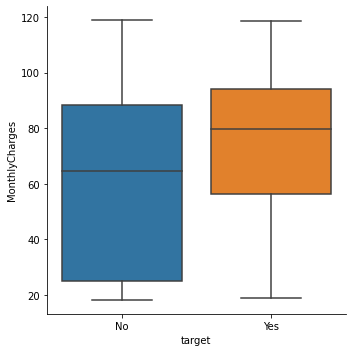

In [17]:
#plot showing us that bigger chargers affect churn probability
sns.factorplot(x="target", y = "MonthlyCharges",data = data, kind="box")

In [18]:
#to numeric
#На этот столбец «ругадлось дерево». Я на всякий случай сделал его типа float. 
#Далее оказались текстовые пробелы в колонках, которые не были видны как Nan. Я это утсранил
pd.to_numeric(data['MonthlyCharges'], downcast='float')


0        29.850000
1        56.950001
2        53.849998
3        42.299999
4        70.699997
           ...    
7038     84.800003
7039    103.199997
7040     29.600000
7041     74.400002
7042    105.650002
Name: MonthlyCharges, Length: 7043, dtype: float32

In [19]:
data['MonthlyCharges'].isna().sum()

0

In [20]:
#we have «nulls»
len(data[data['TotalCharges'] == " "])

11

In [21]:
## Drop missing data
data = data[data['TotalCharges'] != " "]
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])

In [22]:
data['target'] = data['target'].map(lambda s :1  if s =='Yes' else 0)

In [23]:
#crerate mask
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

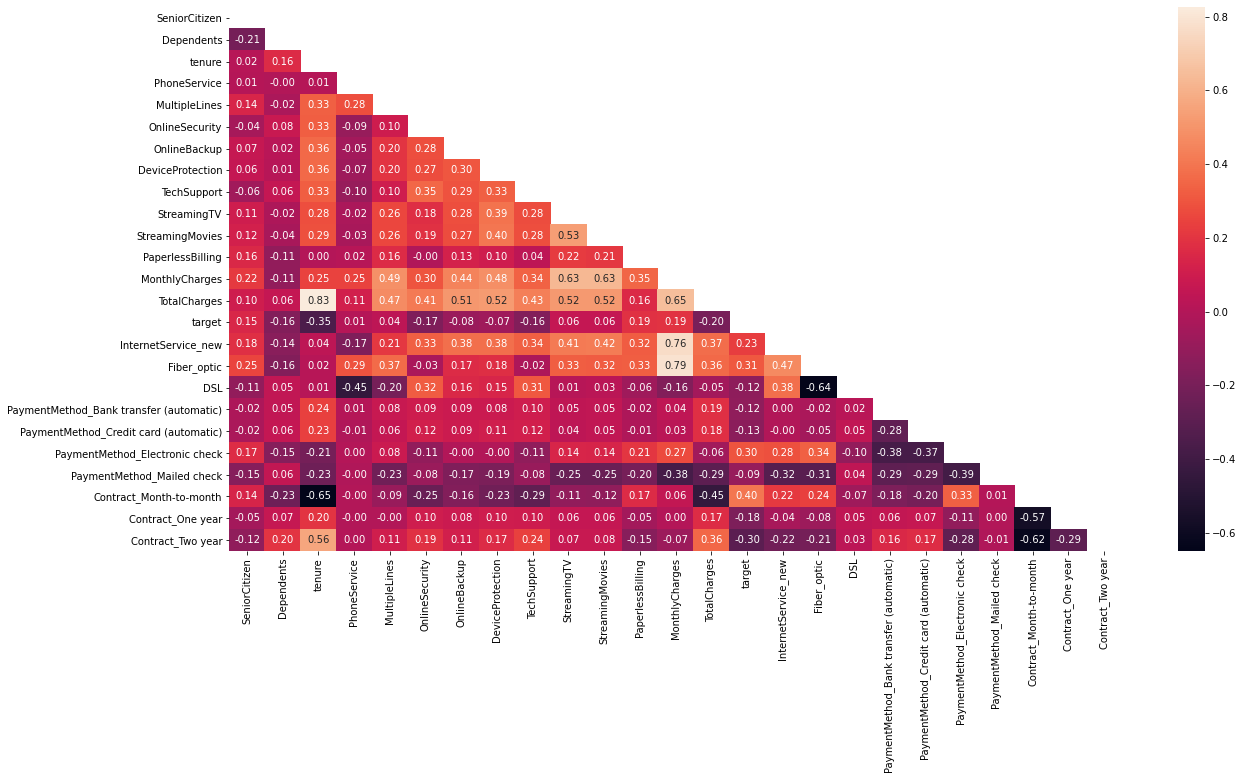

In [24]:
#plot correlations

plt.figure(figsize=(20,10)) 
sns.heatmap(corr, annot=True, fmt='.2f', mask = mask)
plt.show()

на тепловой карте корреляций меня интересовали высокие коррелции выше 0,8 (по модулю) и корр между целевой переменой и «monthlycharges». Я думал, что тут будет сильная корреляция из-за графика ранее, но ошибался. В целом ничего не решил дропать после данной тепловой карты. 

# Creating model and evaluating

In [40]:
X = data.drop(['target'], axis=1)
y = data['target']

In [41]:
#test train split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=SEED, stratify=data['target']
)

### AdaBoost from the box

In [43]:
Ada_classifier = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200
)

In [44]:
Ada_classifier.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=200)

In [45]:
y_pred_ada = Ada_classifier.predict(X_train)

In [46]:
print(classification_report(y_train, y_pred_ada))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      3614
           1       0.69      0.58      0.63      1308

    accuracy                           0.82      4922
   macro avg       0.77      0.74      0.76      4922
weighted avg       0.81      0.82      0.81      4922



хорошие показатели

### XGB from the box

In [47]:
XGB_classifier = XGBClassifier()
XGB_classifier.fit(X_train, y_train,eval_metric='logloss')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [48]:
y_pred_XGB = XGB_classifier.predict(X_train)


In [49]:
print(classification_report(y_train, y_pred_XGB))


              precision    recall  f1-score   support

           0       0.95      0.98      0.96      3614
           1       0.93      0.87      0.90      1308

    accuracy                           0.95      4922
   macro avg       0.94      0.92      0.93      4922
weighted avg       0.95      0.95      0.95      4922



Тут видно как XGB хорошо даже из коробки. высокие показатели полноты, точности и f1 меры.

### LightGBM from the box

In [34]:
GBM_classifier = LGBMClassifier()

In [35]:
GBM_classifier.fit(X_train, y_train)

LGBMClassifier()

In [36]:
y_pred_GBM = GBM_classifier.predict(X_train)
print(classification_report(y_train, y_pred_GBM))


              precision    recall  f1-score   support

           0       0.90      0.94      0.92      3614
           1       0.82      0.72      0.77      1308

    accuracy                           0.88      4922
   macro avg       0.86      0.83      0.85      4922
weighted avg       0.88      0.88      0.88      4922



Тоже неплох из коробки, но LGBM «просел» , если сравнивать с XGB.

### CATBoost from the box

In [37]:
CAT = CatBoostClassifier()

In [38]:
CAT.fit(X_train, y_train)

Learning rate set to 0.020346
0:	learn: 0.6782327	total: 70.7ms	remaining: 1m 10s
1:	learn: 0.6646312	total: 77.5ms	remaining: 38.7s
2:	learn: 0.6511105	total: 82.3ms	remaining: 27.4s
3:	learn: 0.6385325	total: 86.1ms	remaining: 21.4s
4:	learn: 0.6267274	total: 92.9ms	remaining: 18.5s
5:	learn: 0.6159129	total: 97.5ms	remaining: 16.2s
6:	learn: 0.6063673	total: 101ms	remaining: 14.4s
7:	learn: 0.5961837	total: 106ms	remaining: 13.2s
8:	learn: 0.5870339	total: 111ms	remaining: 12.2s
9:	learn: 0.5784836	total: 115ms	remaining: 11.4s
10:	learn: 0.5702877	total: 120ms	remaining: 10.8s
11:	learn: 0.5628367	total: 126ms	remaining: 10.3s
12:	learn: 0.5550124	total: 129ms	remaining: 9.8s
13:	learn: 0.5483861	total: 136ms	remaining: 9.58s
14:	learn: 0.5414347	total: 141ms	remaining: 9.24s
15:	learn: 0.5350384	total: 145ms	remaining: 8.89s
16:	learn: 0.5291590	total: 149ms	remaining: 8.64s
17:	learn: 0.5232295	total: 154ms	remaining: 8.43s
18:	learn: 0.5182235	total: 160ms	remaining: 8.24s
19:	l

180:	learn: 0.3842057	total: 945ms	remaining: 4.27s
181:	learn: 0.3840486	total: 952ms	remaining: 4.28s
182:	learn: 0.3837711	total: 956ms	remaining: 4.26s
183:	learn: 0.3836059	total: 960ms	remaining: 4.26s
184:	learn: 0.3834686	total: 965ms	remaining: 4.25s
185:	learn: 0.3832688	total: 970ms	remaining: 4.25s
186:	learn: 0.3831361	total: 977ms	remaining: 4.25s
187:	learn: 0.3829717	total: 983ms	remaining: 4.24s
188:	learn: 0.3827377	total: 989ms	remaining: 4.25s
189:	learn: 0.3827082	total: 993ms	remaining: 4.23s
190:	learn: 0.3825686	total: 1000ms	remaining: 4.23s
191:	learn: 0.3824348	total: 1s	remaining: 4.23s
192:	learn: 0.3823560	total: 1.01s	remaining: 4.23s
193:	learn: 0.3822382	total: 1.02s	remaining: 4.22s
194:	learn: 0.3820505	total: 1.02s	remaining: 4.22s
195:	learn: 0.3819788	total: 1.03s	remaining: 4.21s
196:	learn: 0.3818555	total: 1.03s	remaining: 4.21s
197:	learn: 0.3815674	total: 1.04s	remaining: 4.2s
198:	learn: 0.3813363	total: 1.04s	remaining: 4.19s
199:	learn: 0.3

361:	learn: 0.3612204	total: 1.83s	remaining: 3.22s
362:	learn: 0.3610954	total: 1.83s	remaining: 3.22s
363:	learn: 0.3609597	total: 1.84s	remaining: 3.21s
364:	learn: 0.3608542	total: 1.84s	remaining: 3.21s
365:	learn: 0.3606633	total: 1.85s	remaining: 3.2s
366:	learn: 0.3605343	total: 1.85s	remaining: 3.2s
367:	learn: 0.3603460	total: 1.86s	remaining: 3.19s
368:	learn: 0.3602239	total: 1.87s	remaining: 3.19s
369:	learn: 0.3601289	total: 1.87s	remaining: 3.19s
370:	learn: 0.3599113	total: 1.88s	remaining: 3.18s
371:	learn: 0.3598071	total: 1.88s	remaining: 3.17s
372:	learn: 0.3596493	total: 1.88s	remaining: 3.17s
373:	learn: 0.3595301	total: 1.89s	remaining: 3.16s
374:	learn: 0.3594696	total: 1.89s	remaining: 3.15s
375:	learn: 0.3593498	total: 1.9s	remaining: 3.15s
376:	learn: 0.3591902	total: 1.9s	remaining: 3.14s
377:	learn: 0.3589700	total: 1.91s	remaining: 3.14s
378:	learn: 0.3588780	total: 1.91s	remaining: 3.14s
379:	learn: 0.3587159	total: 1.92s	remaining: 3.13s
380:	learn: 0.35

525:	learn: 0.3410173	total: 2.61s	remaining: 2.35s
526:	learn: 0.3409305	total: 2.61s	remaining: 2.34s
527:	learn: 0.3407896	total: 2.62s	remaining: 2.34s
528:	learn: 0.3407063	total: 2.62s	remaining: 2.33s
529:	learn: 0.3405560	total: 2.63s	remaining: 2.33s
530:	learn: 0.3404533	total: 2.63s	remaining: 2.32s
531:	learn: 0.3403301	total: 2.63s	remaining: 2.32s
532:	learn: 0.3402172	total: 2.64s	remaining: 2.31s
533:	learn: 0.3400493	total: 2.64s	remaining: 2.31s
534:	learn: 0.3399644	total: 2.65s	remaining: 2.3s
535:	learn: 0.3398650	total: 2.65s	remaining: 2.3s
536:	learn: 0.3397090	total: 2.66s	remaining: 2.29s
537:	learn: 0.3396129	total: 2.67s	remaining: 2.29s
538:	learn: 0.3394980	total: 2.67s	remaining: 2.29s
539:	learn: 0.3393563	total: 2.68s	remaining: 2.28s
540:	learn: 0.3392971	total: 2.68s	remaining: 2.28s
541:	learn: 0.3392045	total: 2.69s	remaining: 2.27s
542:	learn: 0.3390308	total: 2.7s	remaining: 2.27s
543:	learn: 0.3389362	total: 2.7s	remaining: 2.26s
544:	learn: 0.33

698:	learn: 0.3221510	total: 3.44s	remaining: 1.48s
699:	learn: 0.3220704	total: 3.45s	remaining: 1.48s
700:	learn: 0.3219621	total: 3.46s	remaining: 1.47s
701:	learn: 0.3219038	total: 3.46s	remaining: 1.47s
702:	learn: 0.3217830	total: 3.46s	remaining: 1.46s
703:	learn: 0.3216984	total: 3.47s	remaining: 1.46s
704:	learn: 0.3216270	total: 3.48s	remaining: 1.45s
705:	learn: 0.3215389	total: 3.48s	remaining: 1.45s
706:	learn: 0.3214129	total: 3.48s	remaining: 1.44s
707:	learn: 0.3212598	total: 3.49s	remaining: 1.44s
708:	learn: 0.3211783	total: 3.49s	remaining: 1.43s
709:	learn: 0.3210609	total: 3.5s	remaining: 1.43s
710:	learn: 0.3209958	total: 3.5s	remaining: 1.42s
711:	learn: 0.3209268	total: 3.51s	remaining: 1.42s
712:	learn: 0.3208428	total: 3.51s	remaining: 1.41s
713:	learn: 0.3207658	total: 3.52s	remaining: 1.41s
714:	learn: 0.3206658	total: 3.52s	remaining: 1.4s
715:	learn: 0.3205480	total: 3.52s	remaining: 1.4s
716:	learn: 0.3204652	total: 3.53s	remaining: 1.39s
717:	learn: 0.32

867:	learn: 0.3071509	total: 4.22s	remaining: 642ms
868:	learn: 0.3070614	total: 4.22s	remaining: 637ms
869:	learn: 0.3068934	total: 4.23s	remaining: 632ms
870:	learn: 0.3068045	total: 4.23s	remaining: 627ms
871:	learn: 0.3067444	total: 4.24s	remaining: 622ms
872:	learn: 0.3066877	total: 4.24s	remaining: 617ms
873:	learn: 0.3066032	total: 4.24s	remaining: 612ms
874:	learn: 0.3065401	total: 4.25s	remaining: 607ms
875:	learn: 0.3064822	total: 4.25s	remaining: 602ms
876:	learn: 0.3064108	total: 4.26s	remaining: 597ms
877:	learn: 0.3062965	total: 4.26s	remaining: 592ms
878:	learn: 0.3061950	total: 4.27s	remaining: 588ms
879:	learn: 0.3061391	total: 4.27s	remaining: 583ms
880:	learn: 0.3059765	total: 4.28s	remaining: 578ms
881:	learn: 0.3058488	total: 4.28s	remaining: 573ms
882:	learn: 0.3057755	total: 4.29s	remaining: 568ms
883:	learn: 0.3057180	total: 4.29s	remaining: 563ms
884:	learn: 0.3056369	total: 4.29s	remaining: 558ms
885:	learn: 0.3055990	total: 4.3s	remaining: 553ms
886:	learn: 0

In [39]:
y_pred_CAT = CAT.predict(X_train)
print(classification_report(y_train, y_pred_CAT))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      3614
           1       0.82      0.68      0.75      1308

    accuracy                           0.88      4922
   macro avg       0.86      0.81      0.83      4922
weighted avg       0.87      0.88      0.87      4922



CAT как ADA, но проиграл XGB. Хочу отметить, что самый долгий.
XGBoost из коробки победил!

#### ДАЛЕЕ ПЫТАЮСЬ С МИНИМАЛЬНОЙ НАСТРОЙКОЙ ГИПЕРПАРАМЕТРОВ И КРОССВАЛИДАЦИИ ОБУЧИТЬ МОДЕЛИ И ПСМОТРЕТЬ НА МЕТРИКИ ОЦЕНКИ.

### ADAboost 

In [57]:
Ada_tuned = AdaBoostClassifier()

In [58]:
param_grid_ada = {
    'n_estimators':[10, 50, 100, 500],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1.0]
}

In [59]:
cv_ada = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=SEED)

In [60]:
grid_search_ada = GridSearchCV(estimator=Ada_tuned, param_grid=param_grid_ada, n_jobs=-1, cv=cv_ada, scoring='f1')

In [61]:
result_ada = grid_search_ada.fit(X_train, y_train)

In [62]:
#Like ADA from box
y_pred_ADA = result_ada.predict(X_train)
print(classification_report(y_train, y_pred_ADA))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88      3614
           1       0.68      0.57      0.62      1308

    accuracy                           0.82      4922
   macro avg       0.77      0.74      0.75      4922
weighted avg       0.81      0.82      0.81      4922



Чуть хуже чем из коробки.

### XGB

In [50]:
XGB_tuned = XGBClassifier()

In [51]:
params_grid_XGB = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [52]:
skf_XGB = StratifiedKFold(n_splits=5, shuffle = True, random_state = SEED)

In [53]:
grid_search_XGB = GridSearchCV(estimator=XGB_tuned, param_grid=params_grid_XGB, n_jobs=-1, cv=skf_XGB, scoring='f1')

In [54]:
result_XGB = grid_search_XGB.fit(X_train, y_train)

[19:06:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [55]:
#Worst than «from the box»
y_pred_XGB = result_XGB.predict(X_train)
print(classification_report(y_train, y_pred_XGB))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      3614
           1       0.70      0.57      0.63      1308

    accuracy                           0.82      4922
   macro avg       0.78      0.74      0.76      4922
weighted avg       0.81      0.82      0.82      4922



XGB Хуже чем из коробки.

In [63]:
GBM_tuned= LGBMClassifier()

In [64]:
param_grid_GBM = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100, 300, 400],
    'lambda_l1': [ 0,1, 1.5],
    'lambda_l2': [ 0, 1]
    }

In [66]:
GBM_EST = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary', 
                                   learning_rate=0.01, metric='auc')


In [67]:
skf_GBM = StratifiedKFold(n_splits=5, shuffle = True, random_state = SEED)

In [68]:
gsearch_GBM = GridSearchCV(estimator=GBM_EST, param_grid=param_grid_GBM, cv=skf_GBM)


In [69]:
result_GBM = gsearch_GBM.fit(X_train, y_train)


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.5 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.5 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.5 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_i

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.5 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_i

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.5 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.5 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.5 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.5 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.5 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_i

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.5 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.5 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.5 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_i

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_i

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_i

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_i

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_i

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_i

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_da

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning

In [70]:
#it's better than «from the box»
y_pred_GBM = result_GBM.predict(X_train)
print(classification_report(y_train, y_pred_GBM))

              precision    recall  f1-score   support

           0       0.80      0.97      0.88      3614
           1       0.82      0.34      0.48      1308

    accuracy                           0.81      4922
   macro avg       0.81      0.66      0.68      4922
weighted avg       0.81      0.81      0.77      4922



Метрики по классу «1» хуже,  чем у LGBM из коробки.

### CAT

In [71]:
cat_tuned = CatBoostClassifier()

In [72]:
parameters_cat = {'depth'         : [6,8,10],
                  'learning_rate' : [0.01, 0.05, 0.1],
                  'iterations'    : [30, 50, 100]
                 }

In [73]:
skf_CAT = StratifiedKFold(n_splits=5, shuffle = True, random_state = SEED)

In [74]:
grid_CAT = GridSearchCV(estimator=cat_tuned, param_grid = parameters_cat, cv = skf_CAT , n_jobs=-1)


In [75]:
result_CAT = grid_CAT.fit(X_train, y_train)

0:	learn: 0.6575083	total: 3.39ms	remaining: 336ms
1:	learn: 0.6276991	total: 8.34ms	remaining: 409ms
2:	learn: 0.6003384	total: 12.3ms	remaining: 396ms
3:	learn: 0.5770495	total: 15.8ms	remaining: 379ms
4:	learn: 0.5569916	total: 21.1ms	remaining: 400ms
5:	learn: 0.5393740	total: 26.2ms	remaining: 411ms
6:	learn: 0.5247356	total: 31.1ms	remaining: 413ms
7:	learn: 0.5129731	total: 35.9ms	remaining: 413ms
8:	learn: 0.5017567	total: 39.4ms	remaining: 398ms
9:	learn: 0.4919198	total: 43.1ms	remaining: 388ms
10:	learn: 0.4842657	total: 48.2ms	remaining: 390ms
11:	learn: 0.4765333	total: 53.2ms	remaining: 390ms
12:	learn: 0.4690308	total: 57.8ms	remaining: 387ms
13:	learn: 0.4625169	total: 61ms	remaining: 375ms
14:	learn: 0.4568376	total: 64.3ms	remaining: 365ms
15:	learn: 0.4516917	total: 67.8ms	remaining: 356ms
16:	learn: 0.4466591	total: 71.6ms	remaining: 349ms
17:	learn: 0.4424141	total: 76.2ms	remaining: 347ms
18:	learn: 0.4391605	total: 80.9ms	remaining: 345ms
19:	learn: 0.4357409	tot

In [76]:
#The best one
y_pred_CAT = result_CAT.predict(X_train)
print(classification_report(y_train, y_pred_CAT))

              precision    recall  f1-score   support

           0       0.85      0.92      0.89      3614
           1       0.72      0.56      0.63      1308

    accuracy                           0.83      4922
   macro avg       0.79      0.74      0.76      4922
weighted avg       0.82      0.83      0.82      4922



Итог.


